In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import DistanceMetric
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings
pio.renderers.default = "vscode"

In [3]:
df = pd.read_csv('uber-trip-data/uber-raw-data-sep14.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/uber-trip-data/uber-raw-data-sep14.csv'

In [ ]:
df.head()

,Date/Time,Lat,Lon,Base
0,9/1/2014 0:01:00,40.2201,-74.0021,B02512
1,9/1/2014 0:01:00,40.7500,-74.0027,B02512
2,9/1/2014 0:03:00,40.7559,-73.9864,B02512
3,9/1/2014 0:06:00,40.7450,-73.9889,B02512
4,9/1/2014 0:11:00,40.8145,-73.9444,B02512


In [ ]:
df.shape

(1028136, 4)

# Preprocessing

In [ ]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'],format='%m/%d/%Y %H:%M:%S')

In [ ]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'],format='%m/%d/%Y %H:%M:%S')
df['Day'] = df['Date/Time'].dt.day
df['DayOfWeek'] = df['Date/Time'].dt.dayofweek
df['DayOfWeekLabel'] = df['Date/Time'].dt.day_name()
df['Month'] = df['Date/Time'].dt.month
df['Year'] = df['Date/Time'].dt.year
df['Hour'] = df['Date/Time'].dt.hour
df['Minute'] = df['Date/Time'].dt.minute

In [ ]:
df["DayOfWeekAndHour"] = df["DayOfWeekLabel"] + "_" + df["Hour"].astype(str)+"h"

In [ ]:
df.isna().sum()

Date/Time           0
Lat                 0
Lon                 0
Base                0
Day                 0
DayOfWeek           0
DayOfWeekLabel      0
Month               0
Year                0
Hour                0
Minute              0
DayOfWeekAndHour    0
dtype: int64

In [ ]:
df.head()

,Date/Time,Lat,Lon,Base,Day,DayOfWeek,DayOfWeekLabel,Month,Year,Hour,Minute,DayOfWeekAndHour
0,2014-09-01 00:01:00,40.2201,-74.0021,B02512,1,0,Monday,9,2014,0,1,Monday_0h
1,2014-09-01 00:01:00,40.7500,-74.0027,B02512,1,0,Monday,9,2014,0,1,Monday_0h
2,2014-09-01 00:03:00,40.7559,-73.9864,B02512,1,0,Monday,9,2014,0,3,Monday_0h
3,2014-09-01 00:06:00,40.7450,-73.9889,B02512,1,0,Monday,9,2014,0,6,Monday_0h
4,2014-09-01 00:11:00,40.8145,-73.9444,B02512,1,0,Monday,9,2014,0,11,Monday_0h


In [ ]:
numeric_features = ['Lat', 'Lon']
#categorical_features = ['Base']

In [ ]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    ])


In [ ]:
X = preprocessor.fit_transform(df)

In [ ]:
X

array([[-12.71465439,  -0.51931048],
       [  0.26399745,  -0.52959958],
       [  0.40850405,  -0.25007886],
       ...,
       [  2.75979784,   0.68451499],
       [ -0.76224431,  -0.59647878],
       [ -0.61773772,   0.38098635]])

## EDA

#### Journeys By Month

In [ ]:
pickup_time_df = df.groupby(by = "Date/Time").size().to_frame().reset_index()
pickup_time_df.rename(columns = {0:'nb_journeys'}, inplace = True)
pickup_time_df.head()

,Date/Time,nb_journeys
0,2014-09-01 00:00:00,13
1,2014-09-01 00:01:00,18
2,2014-09-01 00:02:00,13
3,2014-09-01 00:03:00,10
4,2014-09-01 00:04:00,14


In [ ]:
# Visualising number of journeys depending on the day of the month and the hour of the day.
fig = px.line(x=pickup_time_df["Date/Time"], y = pickup_time_df["nb_journeys"])
fig.update_layout(
    title="Evolution of number of Uber journeys over a month",
    xaxis_title="Time",
    yaxis_title="Nb journeys"
    )
fig.show()

#### Journeys By Month Day

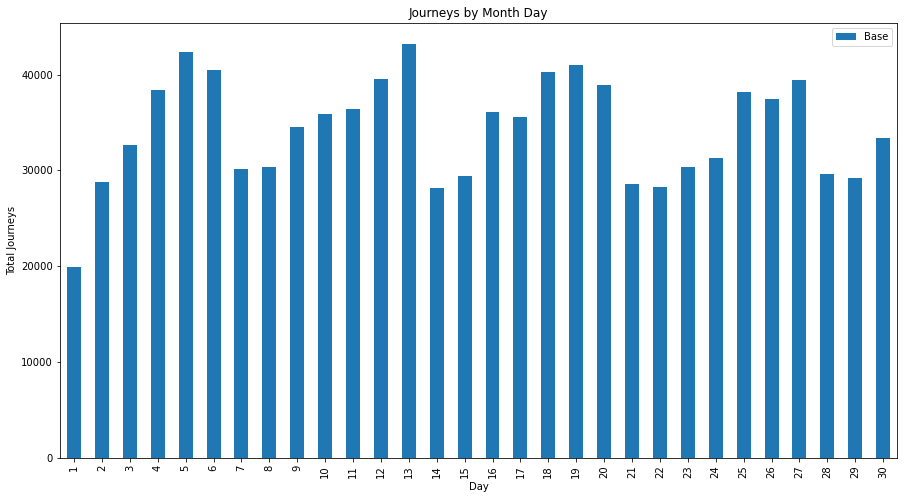

In [ ]:
uber_monthdays = df.pivot_table(index=['Day'],
                                  values='Base',
                                  aggfunc='count')
uber_monthdays.plot(kind='bar', figsize=(15,8))
plt.ylabel('Total Journeys')
plt.title('Journeys by Month Day');

#### Journeys By Weakdays

<AxesSubplot:title={'center':'Bar Plot for Weekdays trips'}, xlabel='day'>

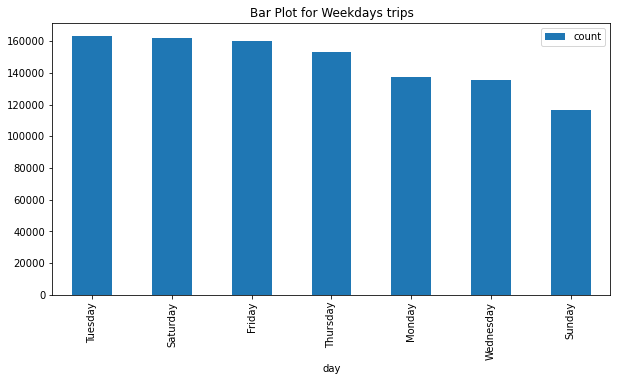

In [ ]:
uber_weekdays = df['DayOfWeekLabel'].value_counts().reset_index().rename(columns={'index':'day','DayOfWeekLabel':'count'})

uber_weekdays.plot(
    kind='bar',
    x='day',
    y='count',
    title='Bar Plot for Weekdays trips',
    figsize=(10, 5)
)

#### Journeys by Hour

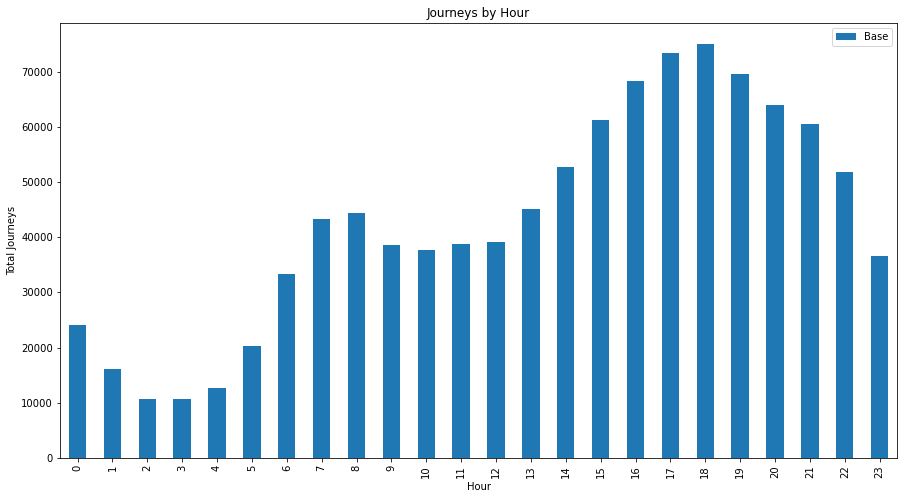

In [ ]:
uber_hour = df.pivot_table(index=['Hour'],
                                  values='Base',
                                  aggfunc='count')
uber_hour.plot(kind='bar', figsize=(15,8))
plt.ylabel('Total Journeys')
plt.title('Journeys by Hour');

## Model

##### Select $K$ optimal clusters

##### Elbow Method

In [ ]:
# Let's create a loop that will collect the Within-sum-of-square (wcss) for each value K 
# Let's use .inertia_ parameter to get the within sum of square value for each value K 
wcss =  []
k = []
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    k.append(i)
    # print("WCSS for K={} --> {}".format(i, wcss[-1]))

print(wcss)

# Create DataFrame
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)

# Create figure
fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)

# Create title and axis labels
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)

# Render
#fig.show(renderer="notebook")
# fig.show(renderer="iframe") # if using workspace
fig.show() # if using workspace

## Silhouette 👥

Let's now double check with the Silhouette method. We will use Sklearn again to get <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html?highlight=silhouette#sklearn.metrics.silhouette_score" target="_blank">silhouette scores.</a>

In [ ]:
# Import silhouette score
from sklearn.metrics import silhouette_score

# Computer mean silhouette score
sil = []
k = []

## Careful, you need to start at i=2 as silhouette score cannot accept less than 2 labels 
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    sil.append(silhouette_score(X, kmeans.predict(X)))
    k.append(i)
    #print("Silhouette score for K={} is {}".format(i, sil[-1]))

print(sil)

# Create a data frame 
cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)

# Create figure
fig = px.bar(data_frame=cluster_scores,  
             x=k, 
             y=cluster_scores.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
#fig.show(renderer="notebook")
# fig.show(renderer="iframe") # if using workspace
fig.show() # if using workspace

In [ ]:
# define the model
model = KMeans(n_clusters=4)

# fit the model
model.fit(X)

# the prediction assign each example (pickup) to his cluster
clusters = model.predict(X)

In [ ]:
df['Cluster'] = clusters

In [ ]:
# Visualising the clusters on the map
fig = px.scatter_mapbox(df,
                        lat='Lat', 
                        lon='Lon',
                        color='Cluster',
                        zoom=5,
                        height=800,
                        mapbox_style='carto-positron'
                        )
fig.show()

> #### I have my <font color='green'>4 clusters</font>, Go ahead and Analyze those clusters.

## Analysing the results of K-means Clustering

> #### With so many data points, it's a difficult to pick out the characteristics of the clusters.

> #### But Centroid (a new datapoint representing the center of each cluster) is very useful to summary each cluster. 

In [ ]:
# Bring the scaled data back to original values
scaler = preprocessor.named_transformers_['num'].named_steps['scaler']
X_centroids = scaler.inverse_transform(model.cluster_centers_)
X_centroids

array([[ 40.80616216, -73.89663687],
       [ 40.70850756, -73.99155284],
       [ 40.6694178 , -73.76938181],
       [ 40.75690191, -73.98122129]])

In [ ]:
centroids = pd.DataFrame(X_centroids, columns=['Lat', 'Lon'])
centroids['Cluster'] = centroids.index
centroids

,Lat,Lon,Cluster
0,40.806162,-73.896637,0
1,40.708508,-73.991553,1
2,40.669418,-73.769382,2
3,40.756902,-73.981221,3


In [ ]:
fig = px.scatter_mapbox(centroids,
                        lat='Lat', 
                        lon='Lon',
                        color='Cluster',
                        hover_data=['Lat', 'Lon'],
                        zoom=10,
                        size=np.full(centroids.shape[0], 3),
                        height=800,
                        center=dict(lat=40.73, lon=-73.93),
                        mapbox_style='carto-positron',
                        title='Cluster Centroids'
                        )
fig.show()

## The Goal is to visualize hot-zones per hour and per day of week

In [ ]:
# Determining the number of pickup points for each hour of the week
nb_journeys_df = df.groupby(['DayOfWeekAndHour', 'Cluster'], sort=False).size().reset_index()
nb_journeys_df.rename(columns ={0: 'nb_journeys'}, inplace=True)
nb_journeys_df.tail(5)

,DayOfWeekAndHour,Cluster,nb_journeys
667,Friday_3h,2,25
668,Saturday_1h,2,56
669,Sunday_2h,2,44
670,Sunday_7h,2,69
671,Thursday_2h,2,10


In [ ]:
centroid_coordinates =  df.groupby(['DayOfWeekAndHour', 'Cluster'], sort=False).apply(calculate_centroid).reset_index()
centroid_coordinates.head()

,DayOfWeekAndHour,Cluster,centroid_latitude,centroid_longitude
0,Monday_0h,2,40.665187,-73.759697
1,Monday_0h,3,40.753210,-73.985474
2,Monday_0h,0,40.814671,-73.913115
3,Monday_0h,1,40.705426,-73.984955
4,Monday_1h,3,40.752382,-73.986121


In [ ]:
# Storing journey numbers as a pandas series
nb_journeys = nb_journeys_df['nb_journeys']

# Finding the optimal driver position for each cluster by taking the centroid of the coordinates of the pickup points included in this cluster. 
# the centroid is more better than the median or mean of the coordinates of the pickup points included in this cluster
hotzones_df = df.groupby(['DayOfWeekAndHour', 'Cluster'], sort=False).median(numeric_only=True).reset_index()
hotzones_df['nb_journeys'] = nb_journeys
hotzones_df['centroid_latitude'] = centroid_coordinates['centroid_latitude']
hotzones_df['centroid_longitude'] = centroid_coordinates['centroid_longitude']

# Checking the resulting dataframe
display(hotzones_df.head(5))

# Checking the length of the dataframe
print('Nb of rows in the dataframe:', len(hotzones_df))

,DayOfWeekAndHour,Cluster,Lat,Lon,Day,DayOfWeek,Month,Year,Hour,Minute,nb_journeys,centroid_latitude,centroid_longitude
0,Monday_0h,2,40.6483,-73.78260,22.0,0.0,9.0,2014.0,0.0,15.0,130,40.665187,-73.759697
1,Monday_0h,3,40.7503,-73.98720,8.0,0.0,9.0,2014.0,0.0,27.0,707,40.753210,-73.985474
2,Monday_0h,0,40.8087,-73.93530,8.0,0.0,9.0,2014.0,0.0,28.0,137,40.814671,-73.913115
3,Monday_0h,1,40.7148,-73.98730,8.0,0.0,9.0,2014.0,0.0,28.0,911,40.705426,-73.984955
4,Monday_1h,3,40.7508,-73.99015,8.0,0.0,9.0,2014.0,1.0,27.0,490,40.752382,-73.986121


Nb of rows in the dataframe: 672


In [ ]:
# Lets us look at an animated map where each frame shows pickup points in a given hour of a day
fig = px.scatter_mapbox(hotzones_df, 
                        lat="centroid_latitude",
                        lon="centroid_longitude",
                        animation_frame='DayOfWeekAndHour',
                        zoom=10,
                        color="Cluster",
                        size=np.full(hotzones_df.shape[0], 0.1),
                        mapbox_style='carto-positron',
                        height=800,
                        title='Clusters Recommended positions per Hour and per Day of week'
                        )
fig.show()

## Comparaison with DBSCAN

In [ ]:
size = 1000
df_new = df.copy().head(size)
X = preprocessor.fit_transform(df_new)

# Define the distance metric to use (in this case, Haversine)
# The Haversine distance is commonly used for calculating distances between points on the surface of the earth
dist = DistanceMetric.get_metric('haversine')

# Calculate the distance matrix
dist_matrix = dist.pairwise(np.radians(X))

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=10, metric='precomputed')
dbscan.fit(dist_matrix)

# Get the cluster labels and the number of clusters
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print("Estimated number of clusters: %d" % n_clusters)

# Assigning a cluster to each row in the dataframe
df_new["Cluster_DB"] = labels

df_new = df_new[df_new['Cluster_DB'] != -1]

# Determining the number of pickup points for each hour of the week
nb_journeys_df = df_new.groupby(['DayOfWeekAndHour', 'Cluster_DB'], sort=False).size().reset_index()
nb_journeys_df.rename(columns ={0: 'nb_journeys'}, inplace=True)

centroid_coordinates =  df_new.groupby(['DayOfWeekAndHour', 'Cluster_DB'], sort=False).apply(calculate_centroid).reset_index()
centroid_coordinates.head()

# Storing journey numbers as a pandas series
nb_journeys = nb_journeys_df['nb_journeys']

# Finding the optimal driver position for each cluster by taking the centroid of the coordinates of the pickup points included in this cluster. 
# the centroid is more better than the median or mean of the coordinates of the pickup points included in this cluster
hotzones_df = df_new.groupby(['DayOfWeekAndHour', 'Cluster_DB'], sort=False).median(numeric_only=True).reset_index()
hotzones_df['nb_journeys'] = nb_journeys
hotzones_df['centroid_latitude'] = centroid_coordinates['centroid_latitude']
hotzones_df['centroid_longitude'] = centroid_coordinates['centroid_longitude']

# Lets us look at an animated map where each frame shows pickup points in a given hour of a day
fig = px.scatter_mapbox(hotzones_df, 
                        lat="centroid_latitude",
                        lon="centroid_longitude",
                        animation_frame='DayOfWeekAndHour',
                        zoom=10,
                        color="Cluster_DB",
                        size=np.full(hotzones_df.shape[0], 0.1),
                        mapbox_style='carto-positron',
                        height=800,
                        title='DBSCAN Clusters Recommended positions per Hour and per Day of week'
                        )
fig.show()

### Sources

- [does-the-mean-of-latitude-and-longitude-make-sense](https://gis.stackexchange.com/questions/164322/does-the-mean-of-latitude-and-longitude-make-sense)